In [24]:
#Data imports

import pandas as pd

isotherm_mo = pd.read_csv('isotherm_mo_data.csv', index_col=None)

isotherm_mo.head(3)

,Ce_MX_MSN,Qe_MX_MSN,Ce_MX_MSN_SH,Qe_MX_MSN_SH,Ce_MX_Am_MSN,Qe_MX_Am_MSN
0,0.254514,6.981946,0.010000,8.507988,0.083929,7.664285
1,1.786319,12.854724,0.020000,20.461884,0.168069,19.327726
2,4.917933,20.328267,0.050503,39.797986,0.215325,39.138699


In [25]:
#define Ce and Qe for each material

Ce_m = isotherm_mo.Ce_MX_MSN #Ce of MX-MSN
Ce_s = isotherm_mo.Ce_MX_MSN_SH #Ce of MX-MSN-SH
Ce_a = isotherm_mo.Ce_MX_Am_MSN #Ce of MX-Am-MSN

Qe_m = isotherm_mo.Qe_MX_MSN #qe of MX-MSN
Qe_s = isotherm_mo.Qe_MX_MSN_SH #qe of MX-MSN-SH
Qe_a = isotherm_mo.Qe_MX_Am_MSN #qe of MX-Am-MSN

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ================================================================
# Fitting Functions
# ================================================================

def langmuir_fit(Ce, Qe):
    """
    Fits adsorption data to the Langmuir isotherm model.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
    Returns:
        Qm (float): Maximum adsorption capacity (mg/g).
        KL (float): Langmuir constant (L/mg).
        R2 (float): Coefficient of determination.
    """
    # Linearized Langmuir equation: Ce/Qe = 1/(Qm*KL) + Ce/Qm
    x = np.array(Ce)
    y = np.array(Ce) / np.array(Qe)

    # Linear regression
    slope, intercept = np.polyfit(x, y, 1)
    Qm = 1 / slope
    KL = slope / intercept

    # Calculate R²
    y_pred = slope * x + intercept
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    R2 = 1 - (ss_res / ss_tot)

    return Qm, KL, R2


def freundlich_fit(Ce, Qe):
    """
    Fits adsorption data to the Freundlich isotherm model.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
    Returns:
        KF (float): Freundlich constant (mg/g).
        n (float): Adsorption intensity.
        R2 (float): Coefficient of determination.
    """
    # Linearized Freundlich equation: log(Qe) = log(KF) + (1/n)*log(Ce)
    x = np.log10(np.array(Ce))
    y = np.log10(np.array(Qe))

    # Linear regression
    slope, intercept = np.polyfit(x, y, 1)
    KF = 10 ** intercept
    n = 1 / slope

    # Calculate R²
    y_pred = slope * x + intercept
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    R2 = 1 - (ss_res / ss_tot)

    return KF, n, R2


def temkin_fit(Ce, Qe, T=293):
    """
    Fits adsorption data to the Temkin isotherm model.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
        T (float): Temperature in Kelvin (default = 298 K).
    Returns:
        b (float): Temkin constant related to adsorption heat (J/mol).
        AT (float): Temkin isotherm constant (L/mg).
        R2 (float): Coefficient of determination.
    """
    # Linearized Temkin equation: Qe = (RT/b) * ln(AT * Ce)
    R = 8.314  # Universal gas constant (J/mol·K)
    x = np.log(np.array(Ce))
    y = np.array(Qe)

    # Linear regression
    slope, intercept = np.polyfit(x, y, 1)
    b = (R * T) / slope
    AT = np.exp(intercept / slope)

    # Calculate R²
    y_pred = slope * x + intercept
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    R2 = 1 - (ss_res / ss_tot)

    return b, AT, R2


def dr_fit(Ce, Qe, T=293):
    """
    Fits adsorption data to the Dubinin-Radushkevich (D–R) isotherm model.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
        T (float): Temperature in Kelvin (default = 298 K).
    Returns:
        Qm (float): Theoretical maximum adsorption capacity (mg/g).
        beta (float): Activity coefficient related to mean adsorption energy (mol²/J²).
        E (float): Mean adsorption energy (kJ/mol).
        R2 (float): Coefficient of determination.
    """
    # Linearized D–R equation: ln(Qe) = ln(Qm) - beta * ε²
    R = 8.314  # Universal gas constant (J/mol·K)
    epsilon = R * T * np.log(1 + 1 / np.array(Ce))
    x = epsilon ** 2
    y = np.log(np.array(Qe))

    # Linear regression
    slope, intercept = np.polyfit(x, y, 1)
    Qm = np.exp(intercept)
    beta = -slope
    E = 1 / np.sqrt(2 * beta) / 1000  # Convert to kJ/mol

    # Calculate R²
    y_pred = slope * x + intercept
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    R2 = 1 - (ss_res / ss_tot)

    return Qm, beta, E, R2


# ================================================================
# Visualization Functions
# ================================================================

def langmuir_plot(Ce, Qe, Qm, KL):
    """
    Plots the Langmuir isotherm fit.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
        Qm (float): Maximum adsorption capacity (mg/g).
        KL (float): Langmuir constant (L/mg).
    """
    x = np.array(Ce)
    y = np.array(Ce) / np.array(Qe)
    y_fit = (1 / (Qm * KL)) + (x / Qm)

    plt.scatter(x, y, color='blue', label='Data')
    plt.plot(x, y_fit, 'r--', label='Langmuir Fit')
    plt.xlabel('Ce (mg/L)')
    plt.ylabel('Ce/Qe (L/g)')
    plt.title('Langmuir Isotherm')
    plt.legend()
    plt.grid()
    plt.show()


def freundlich_plot(Ce, Qe, KF, n):
    """
    Plots the Freundlich isotherm fit.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
        KF (float): Freundlich constant (mg/g).
        n (float): Adsorption intensity.
    """
    x = np.log10(np.array(Ce))
    y = np.log10(np.array(Qe))
    y_fit = np.log10(KF) + (1 / n) * x

    plt.scatter(x, y, color='green', label='Data')
    plt.plot(x, y_fit, 'r--', label='Freundlich Fit')
    plt.xlabel('log(Ce)')
    plt.ylabel('log(Qe)')
    plt.title('Freundlich Isotherm')
    plt.legend()
    plt.grid()
    plt.show()


def temkin_plot(Ce, Qe, b, AT):
    """
    Plots the Temkin isotherm fit.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
        b (float): Temkin constant related to adsorption heat (J/mol).
        AT (float): Temkin isotherm constant (L/mg).
    """
    x = np.log(np.array(Ce))
    y = np.array(Qe)
    y_fit = (8.314 * 298 / b) * np.log(AT * np.array(Ce))

    plt.scatter(x, y, color='purple', label='Data')
    plt.plot(x, y_fit, 'r--', label='Temkin Fit')
    plt.xlabel('ln(Ce)')
    plt.ylabel('Qe (mg/g)')
    plt.title('Temkin Isotherm')
    plt.legend()
    plt.grid()
    plt.show()


def dr_plot(Ce, Qe, Qm, beta):
    """
    Plots the Dubinin-Radushkevich (D–R) isotherm fit.
    Inputs:
        Ce (array): Equilibrium concentration (mg/L).
        Qe (array): Adsorbed amount at equilibrium (mg/g).
        Qm (float): Theoretical maximum adsorption capacity (mg/g).
        beta (float): Activity coefficient related to mean adsorption energy (mol²/J²).
    """
    R = 8.314  # Universal gas constant (J/mol·K)
    T = 293    # Temperature in Kelvin
    epsilon = R * T * np.log(1 + 1 / np.array(Ce))
    x = epsilon ** 2
    y = np.log(np.array(Qe))
    y_fit = np.log(Qm) - beta * x

    plt.scatter(x, y, color='orange', label='Data')
    plt.plot(x, y_fit, 'r--', label='D-R Fit')
    plt.xlabel('ε² (J²/mol²)')
    plt.ylabel('ln(Qe)')
    plt.title('Dubinin-Radushkevich Isotherm')
    plt.legend()
    plt.grid()
    plt.show()


# MX-MSN

MX-MSN MO dye
Langmuir: Qm = 59.92 mg/g, KL = 0.127 L/mg, R² = 0.820


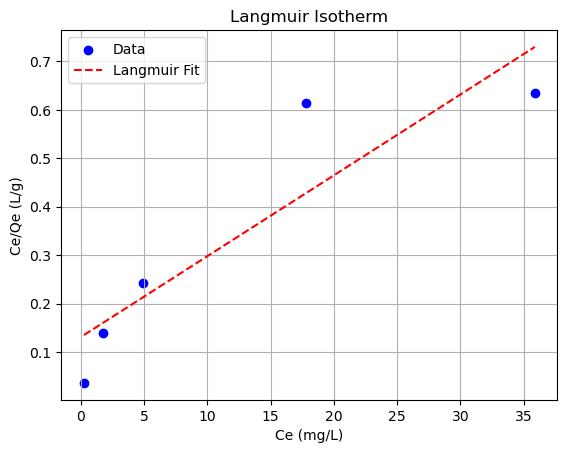

Freundlich: KF = 11.06 mg/g, n = 2.51, R² = 0.964


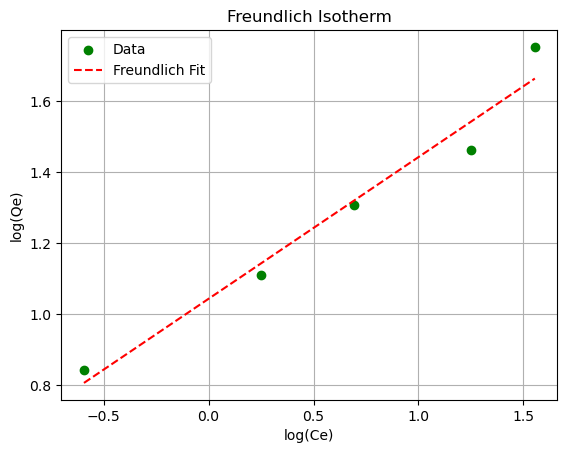

Temkin: b = 279.47 J/mol, AT = 4.173 L/mg, R² = 0.775


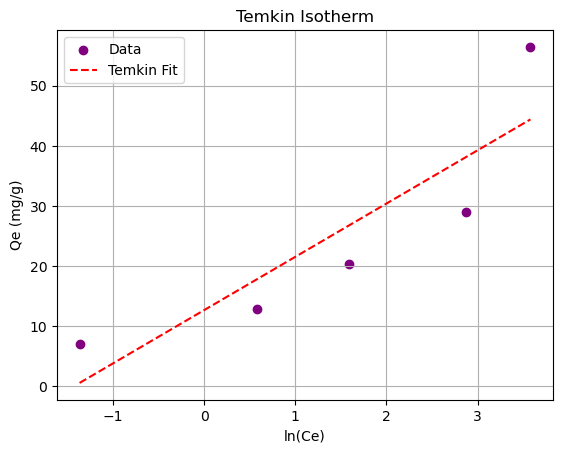

D-R: Qm = 26.74 mg/g, beta = 9.24e-08 mol²/J², E = 2.33 kJ/mol, R² = 0.593


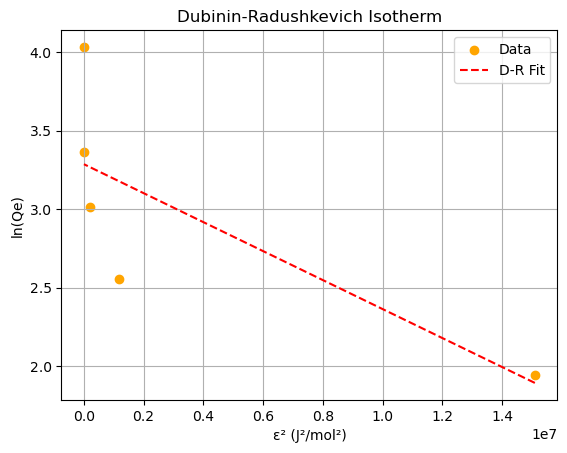

In [21]:
# ================================================================
# Usage for diff materials
# ================================================================

# Fit and visualize Langmuir model
print("MX-MSN MO dye")
Qm, KL, R2_langmuir = langmuir_fit(Ce_m, Qe_m)
print(f"Langmuir: Qm = {Qm:.2f} mg/g, KL = {KL:.3f} L/mg, R² = {R2_langmuir:.3f}")
langmuir_plot(Ce_m, Qe_m, Qm, KL)

# Fit and visualize Freundlich model
KF, n, R2_freundlich = freundlich_fit(Ce_m, Qe_m)
print(f"Freundlich: KF = {KF:.2f} mg/g, n = {n:.2f}, R² = {R2_freundlich:.3f}")
freundlich_plot(Ce_m, Qe_m, KF, n)

# Fit and visualize Temkin model
b, AT, R2_temkin = temkin_fit(Ce_m, Qe_m)
print(f"Temkin: b = {b:.2f} J/mol, AT = {AT:.3f} L/mg, R² = {R2_temkin:.3f}")
temkin_plot(Ce_m, Qe_m, b, AT)

# Fit and visualize D–R model
Qm_dr, beta, E, R2_dr = dr_fit(Ce_m, Qe_m)
print(f"D-R: Qm = {Qm_dr:.2f} mg/g, beta = {beta:.2e} mol²/J², E = {E:.2f} kJ/mol, R² = {R2_dr:.3f}")
dr_plot(Ce_m, Qe_m, Qm_dr, beta)

# MX-MSN-SH

MX-MSN-SH for MO dye
Langmuir: Qm = 105.03 mg/g, KL = 1.469 L/mg, R² = 0.982


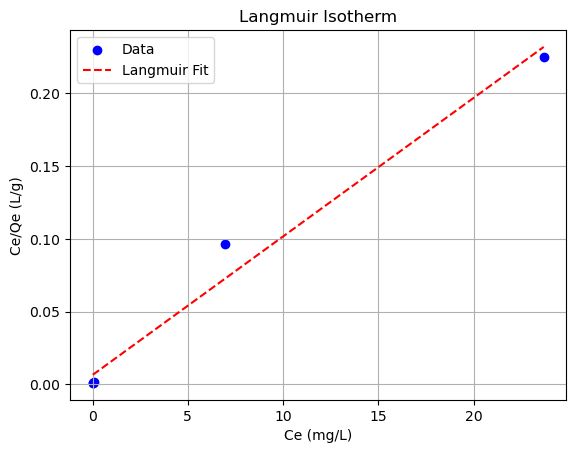

Freundlich: KF = 48.65 mg/g, n = 3.89, R² = 0.835


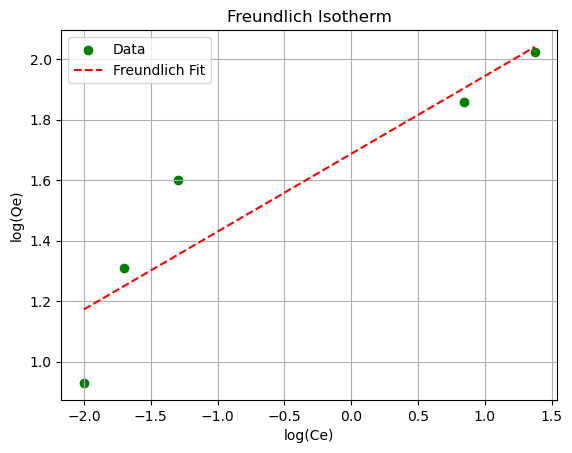

Temkin: b = 225.98 J/mol, AT = 346.045 L/mg, R² = 0.950


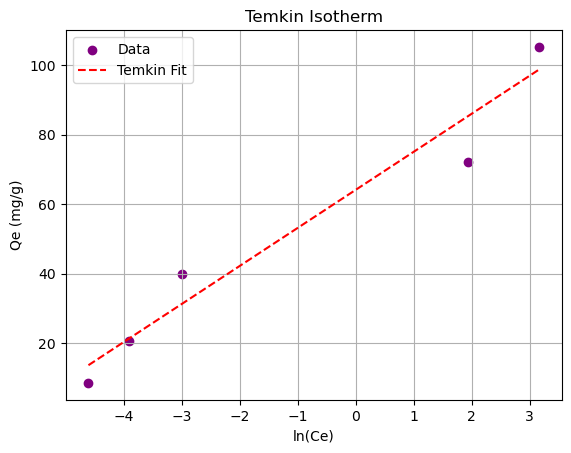

D-R: Qm = 92.01 mg/g, beta = 1.77e-08 mol²/J², E = 5.31 kJ/mol, R² = 0.968


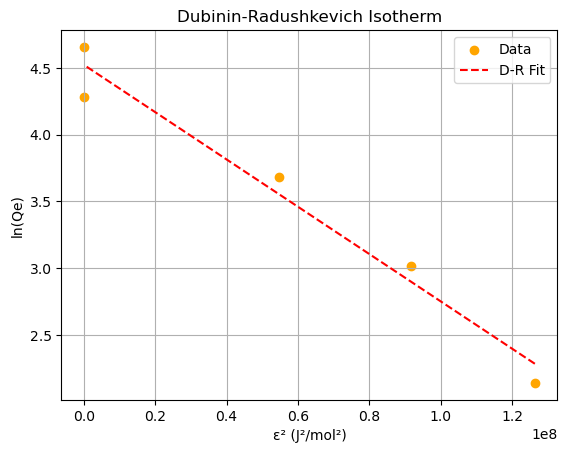

In [26]:
# ================================================================
# MX-MSN-SH
# ================================================================

# Fit and visualize Langmuir model
print("MX-MSN-SH for MO dye")
Qm, KL, R2_langmuir = langmuir_fit(Ce_s, Qe_s)
print(f"Langmuir: Qm = {Qm:.2f} mg/g, KL = {KL:.3f} L/mg, R² = {R2_langmuir:.3f}")
langmuir_plot(Ce_s, Qe_s, Qm, KL)

# Fit and visualize Freundlich model
KF, n, R2_freundlich = freundlich_fit(Ce_s, Qe_s)
print(f"Freundlich: KF = {KF:.2f} mg/g, n = {n:.2f}, R² = {R2_freundlich:.3f}")
freundlich_plot(Ce_s, Qe_s, KF, n)

# Fit and visualize Temkin model
b, AT, R2_temkin = temkin_fit(Ce_s, Qe_s)
print(f"Temkin: b = {b:.2f} J/mol, AT = {AT:.3f} L/mg, R² = {R2_temkin:.3f}")
temkin_plot(Ce_s, Qe_s, b, AT)

# Fit and visualize D–R model
Qm_dr, beta, E, R2_dr = dr_fit(Ce_s, Qe_s)
print(f"D-R: Qm = {Qm_dr:.2f} mg/g, beta = {beta:.2e} mol²/J², E = {E:.2f} kJ/mol, R² = {R2_dr:.3f}")
dr_plot(Ce_s, Qe_s, Qm_dr, beta)

# MX-Am-MSN

MX-Am-MSN for MO dye
Langmuir: Qm = 255.03 mg/g, KL = 0.581 L/mg, R² = 0.873


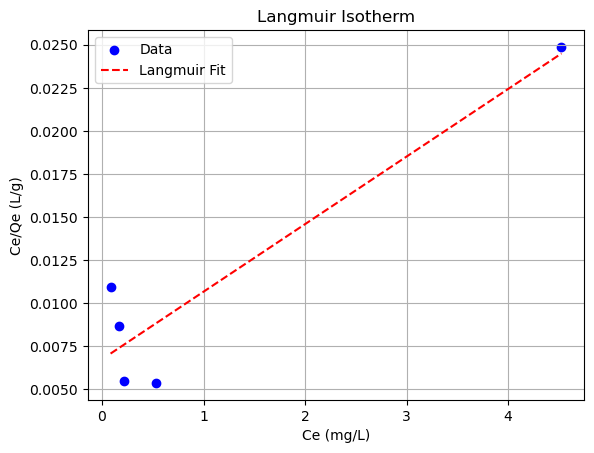

Freundlich: KF = 84.02 mg/g, n = 1.33, R² = 0.845


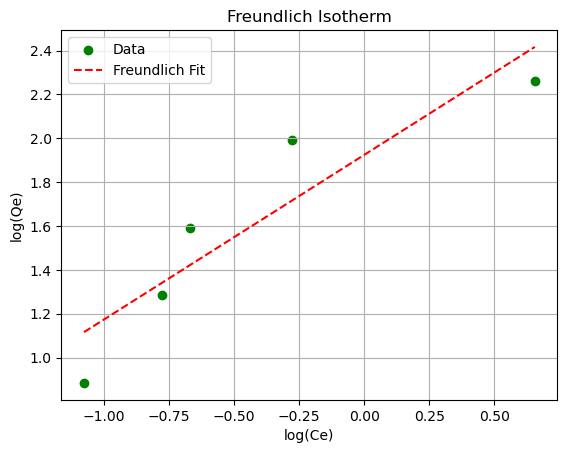

Temkin: b = 52.74 J/mol, AT = 11.985 L/mg, R² = 0.980


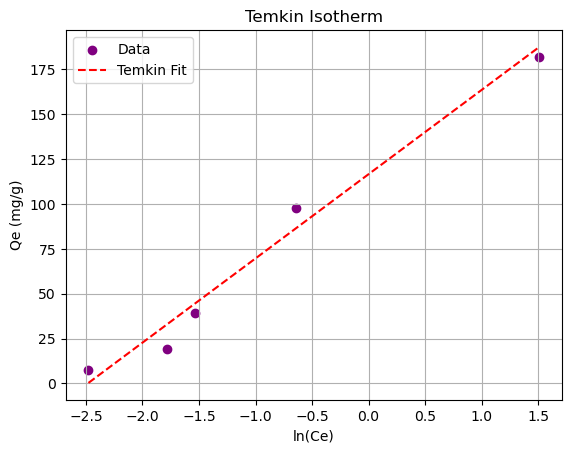

D-R: Qm = 168.29 mg/g, beta = 8.36e-08 mol²/J², E = 2.45 kJ/mol, R² = 0.980


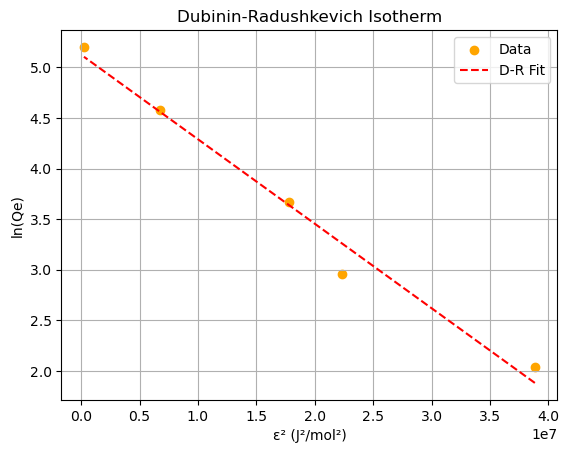

In [27]:
# ================================================================
# Usage for MX-Am-MSN
# ================================================================

# Fit and visualize Langmuir model
print("MX-Am-MSN for MO dye")
Qm, KL, R2_langmuir = langmuir_fit(Ce_a, Qe_a)
print(f"Langmuir: Qm = {Qm:.2f} mg/g, KL = {KL:.3f} L/mg, R² = {R2_langmuir:.3f}")
langmuir_plot(Ce_a, Qe_a, Qm, KL)

# Fit and visualize Freundlich model
KF, n, R2_freundlich = freundlich_fit(Ce_a, Qe_a)
print(f"Freundlich: KF = {KF:.2f} mg/g, n = {n:.2f}, R² = {R2_freundlich:.3f}")
freundlich_plot(Ce_a, Qe_a, KF, n)

# Fit and visualize Temkin model
b, AT, R2_temkin = temkin_fit(Ce_a, Qe_a)
print(f"Temkin: b = {b:.2f} J/mol, AT = {AT:.3f} L/mg, R² = {R2_temkin:.3f}")
temkin_plot(Ce_a, Qe_a, b, AT)

# Fit and visualize D–R model
Qm_dr, beta, E, R2_dr = dr_fit(Ce_a, Qe_a)
print(f"D-R: Qm = {Qm_dr:.2f} mg/g, beta = {beta:.2e} mol²/J², E = {E:.2f} kJ/mol, R² = {R2_dr:.3f}")
dr_plot(Ce_a, Qe_a, Qm_dr, beta)

### ~That's the end for isotherm modelling of crystal violet (CV) dye adsorption~

# Methyl orange dye ends here ...

### Let's start with data imports and renaming to ease working with it